
Starting Genetic Variant Classification Analysis
Data reduced to 800000 samples to manage memory.

Preprocessing data for population-aware model
Generated 2079 named features for population-aware model
Preprocessing data for non-population-aware model
Generated 71 named features for non-population-aware model
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



Best parameters found: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Best Balanced Accuracy Score: 0.7935657958322428
Grid search checkpoint saved to grid_search_checkpoint.pkl

Final Classification Report on Test Set:
              precision    recall  f1-score   support

      benign       0.84      0.85      0.84      7231
  pathogenic       0.91      0.93      0.92      4223
   uncertain       0.65      0.63      0.64      3523

    accuracy                           0.82     14977
   macro avg       0.80      0.80      0.80     14977
weighted avg       0.82      0.82      0.82     14977

Multiclass ROC AUC per class: {0: 0.9392200695266524, 1: 0.9906322902676439, 2: 0.900216918718327}
Optimal thresholds per class: {0: 0.5025329, 1: 0.2838883, 2: 0.1351047}

=== Training and Evaluating Non-Population-Aware Model ===


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



Classification Report:
              precision    recall  f1-score   support

      benign       0.81      0.89      0.85      7231
  pathogenic       0.92      0.92      0.92      4223
   uncertain       0.68      0.53      0.60      3523

    accuracy                           0.81     14977
   macro avg       0.80      0.78      0.79     14977
weighted avg       0.81      0.81      0.81     14977


Accuracy by Population Group:
  Japanese: 0.792
  African American: 0.849
  Gambian: 0.788
  Luhya: 0.798
  Han Chinese: 0.794
  Yoruba: 0.810
  Esan: 0.850
  African Caribbean: 0.854
  Mende: 0.849
  Central European: 0.853
Max accuracy difference: 0.066

Classification Report:
              precision    recall  f1-score   support

      benign       0.81      0.89      0.85      7231
  pathogenic       0.92      0.92      0.92      4223
   uncertain       0.68      0.53      0.59      3523

    accuracy                           0.81     14977
   macro avg       0.80      0.78      0.7

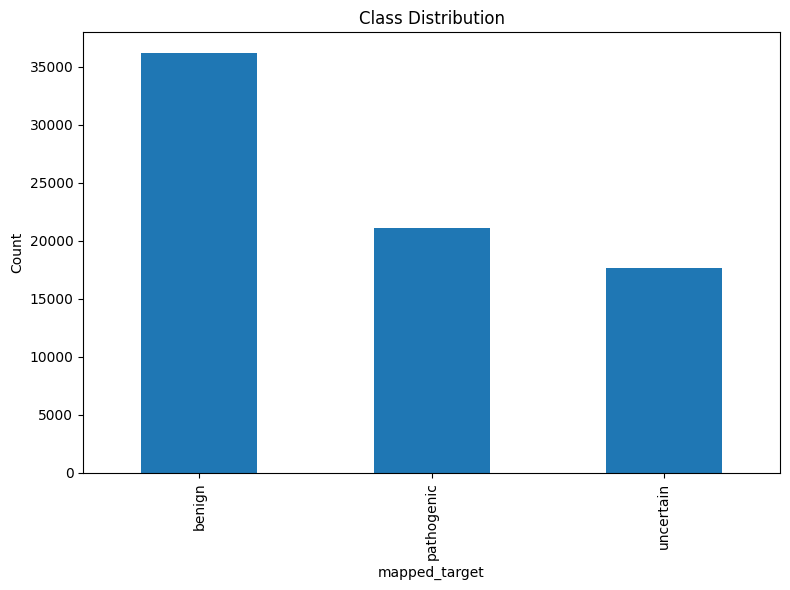

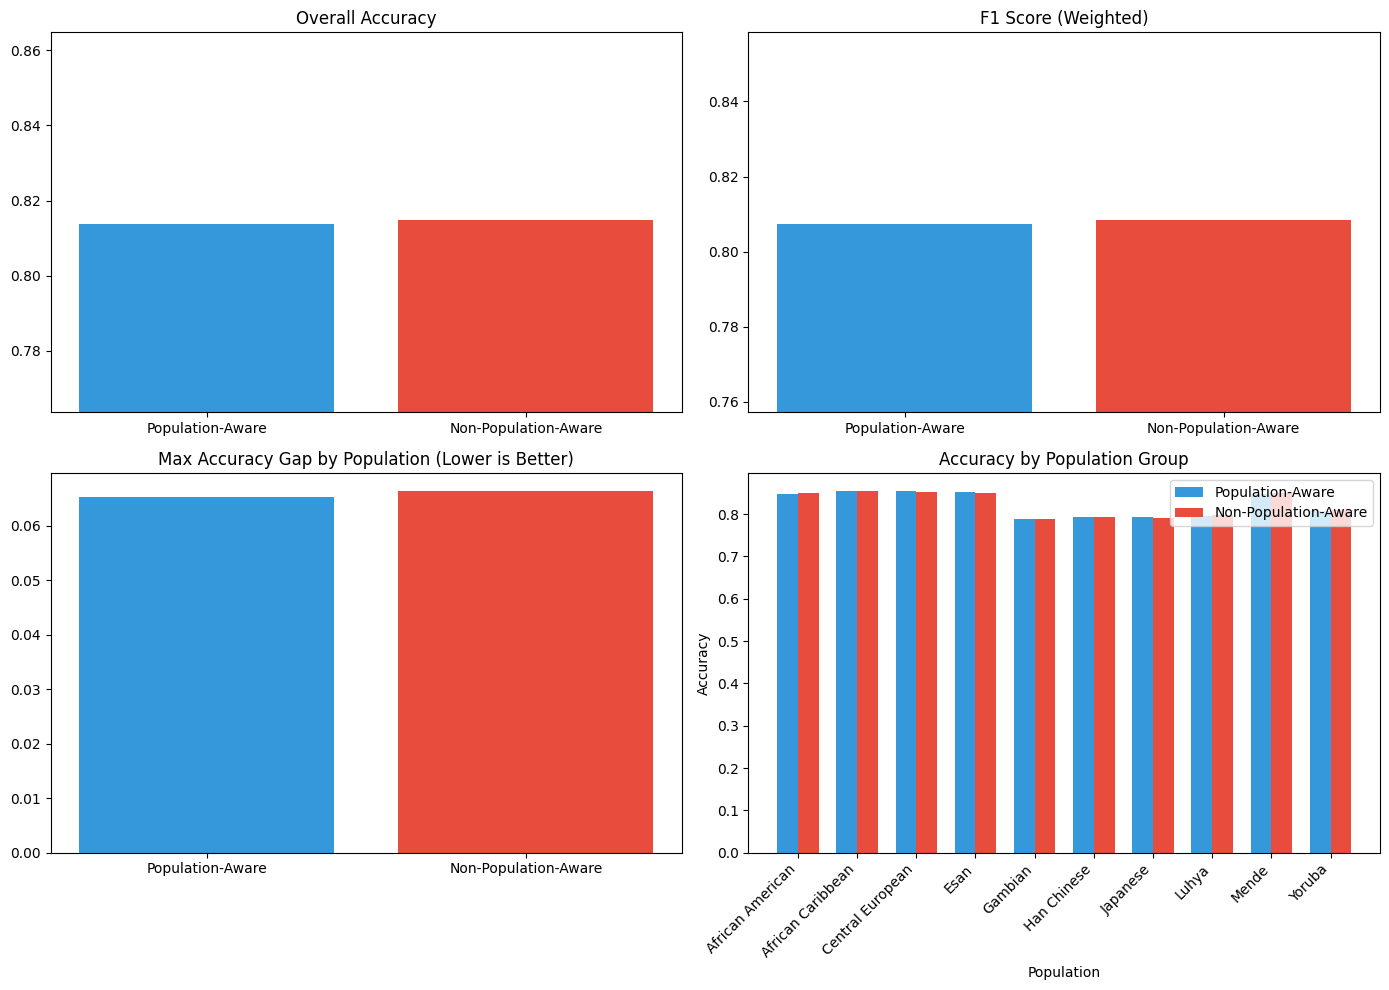

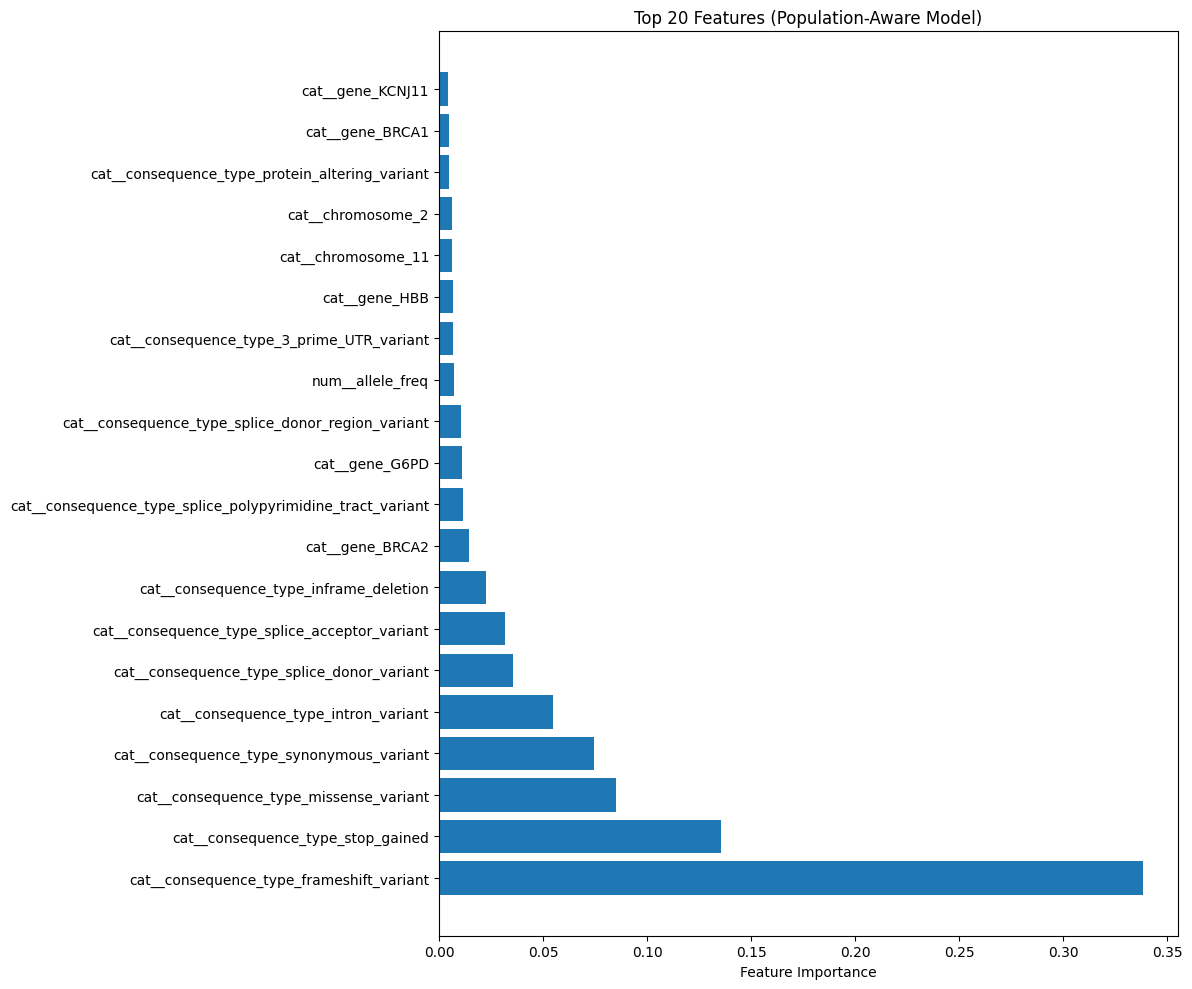

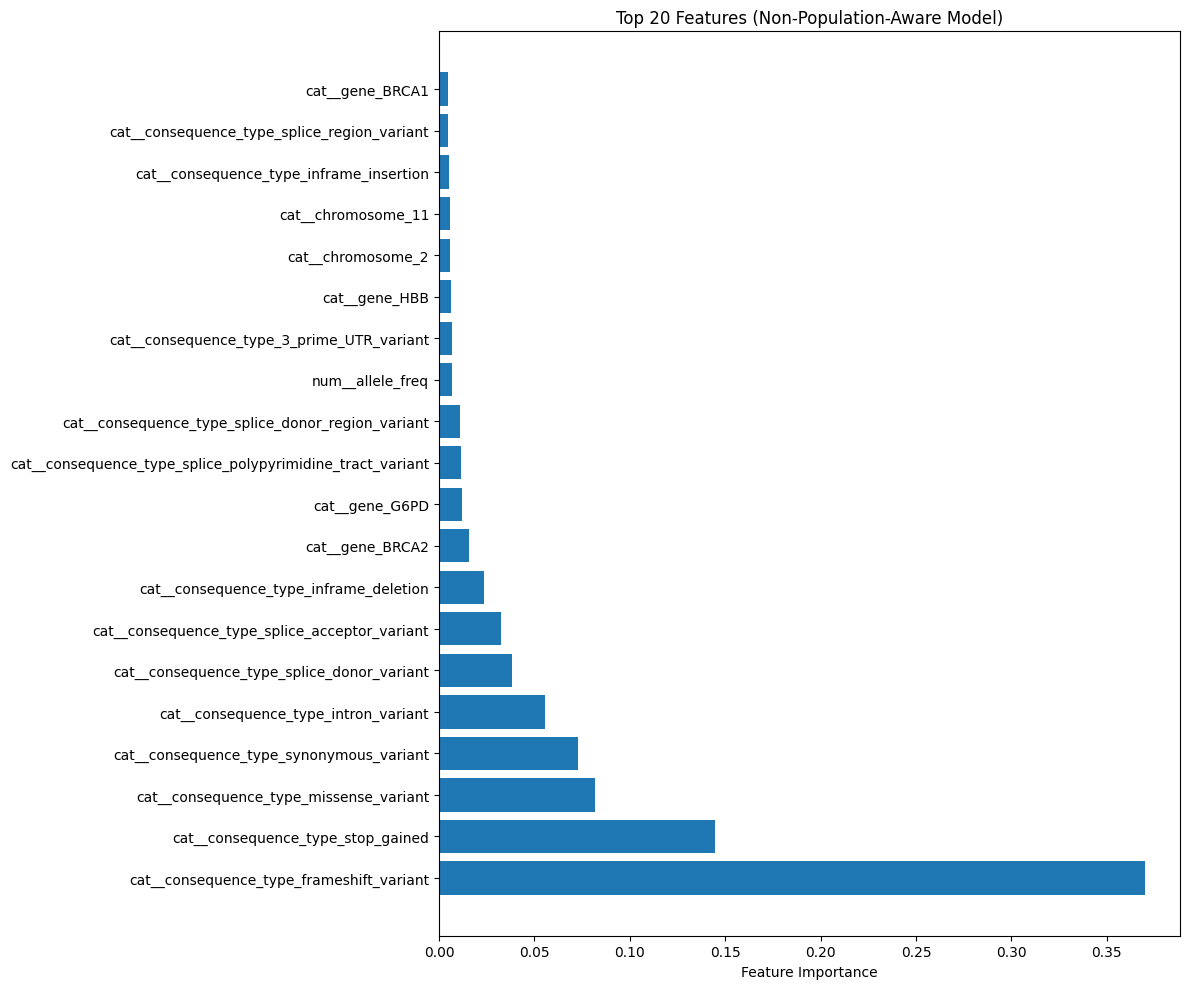

In [1]:
"""
Improved Genetic Variant Classification Framework with Proper Sequence Encoding

This script properly handles DNA sequence data by encoding it appropriately
for machine learning models, comparing population-aware and non-population-aware 
approaches for genetic variant classification.
"""

import os
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, balanced_accuracy_score
)

# For parallel processing and caching
from joblib import Memory
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from tqdm.auto import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ------------------------------
# CONFIGURATION OPTIONS (tweak as needed)
# ------------------------------
USE_SMOTE = False         # Set to True to use SMOTE (may be memory intensive)
DATA_SAMPLE_SIZE = 800000  # Number of rows to sample (adjust for testing/full run)
MODEL_TYPE = "XGBoost"    # Options: "RandomForest", "LogisticRegression", "XGBoost"

# Set file path
FILE_PATH = '/kaggle/input/raw-variant-genetic-data/raw_variant_data.csv'
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Create a memory object for caching (cache directory "cachedir")
memory = Memory(location='./cachedir', verbose=0)

# -----------------------------------------------
# Data Loading and Processing Functions
# -----------------------------------------------
def load_data(file_path: str) -> pd.DataFrame:
    logger.info(f"Loading data from {file_path}")
    dtype_mapping = {
        'gene': 'category',
        'chromosome': 'category',
        'variant_id': 'category',
        'consequence_type': 'category',
        'clinical_significance': 'category',
        'population_name': 'category',
        'region': 'category',
    }
    df = pd.read_csv(file_path, dtype=dtype_mapping, low_memory=False)
    numeric_cols = ['allele_freq', 'allele_count', 'sample_size', 'position']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    logger.info(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

def prepare_target(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Preparing target variable")
    df = df.copy()
    def map_to_classes(label_str):
        if pd.isna(label_str):
            return np.nan
        label = str(label_str).lower()
        if "pathogenic" in label:
            return "pathogenic"
        elif "benign" in label and "pathogenic" not in label:
            return "benign"
        elif "uncertain" in label or "conflicting" in label:
            return "uncertain"
        else:
            return np.nan
    df["mapped_target"] = df["clinical_significance"].apply(map_to_classes)
    df = df.dropna(subset=["mapped_target"])
    label_map = {"benign": 0, "pathogenic": 1, "uncertain": 2}
    df["target_encoded"] = df["mapped_target"].map(label_map)
    class_dist = df["mapped_target"].value_counts()
    logger.info(f"Target class distribution:\n{class_dist}")
    plt.figure(figsize=(8, 6))
    class_dist.plot(kind='bar')
    plt.title('Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig("class_distribution.png")
    return df

def extract_sequence_features(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Extracting sequence-based features")
    df = df.copy()
    if 'allele' in df.columns:
        df['allele'] = df['allele'].fillna('').astype(str)
        df['allele_length'] = df['allele'].str.len()
        df['allele_A_count'] = df['allele'].str.count('A')
        df['allele_C_count'] = df['allele'].str.count('C')
        df['allele_G_count'] = df['allele'].str.count('G')
        df['allele_T_count'] = df['allele'].str.count('T')
        df['allele_GC_content'] = (df['allele_G_count'] + df['allele_C_count']) / df['allele_length'].replace(0, 1)
    if 'allele_string' in df.columns and 'allele' not in df.columns:
        df['allele_string'] = df['allele_string'].fillna('').astype(str)
        df['allele_length'] = df['allele_string'].str.len()
        df['allele_A_count'] = df['allele_string'].str.count('A')
        df['allele_C_count'] = df['allele_string'].str.count('C')
        df['allele_G_count'] = df['allele_string'].str.count('G')
        df['allele_T_count'] = df['allele_string'].str.count('T')
        df['allele_GC_content'] = (df['allele_G_count'] + df['allele_C_count']) / df['allele_length'].replace(0, 1)
    logger.info(f"Extracted sequence features: {df.columns[df.columns.str.contains('allele_')].tolist()}")
    return df

def create_population_features(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Creating population-aware features")
    df = df.copy()
    if 'population_name' in df.columns and 'consequence_type' in df.columns:
        df['pop_consequence'] = df['population_name'].astype(str) + '_' + df['consequence_type'].astype(str)
    if 'population_name' in df.columns and 'gene' in df.columns:
        df['pop_gene'] = df['population_name'].astype(str) + '_' + df['gene'].astype(str)
    if 'allele_freq' in df.columns and 'population_name' in df.columns:
        pop_freq_means = df.groupby(df['population_name'].astype(str))['allele_freq'].mean().to_dict()
        df['pop_allele_freq_mean'] = df['population_name'].astype(str).map(pop_freq_means)
        mean_freq = df['allele_freq'].mean()
        df['pop_allele_freq_mean'] = df['pop_allele_freq_mean'].fillna(mean_freq)
        df['allele_freq_rel'] = df['allele_freq'] / df['pop_allele_freq_mean']
    return df

def add_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['pop_gene_consequence'] = (df['population_name'].astype(str) + "_" +
                                  df['gene'].astype(str) + "_" +
                                  df['consequence_type'].astype(str))
    return df

def get_feature_names(column_transformer):
    # (This function remains unchanged)
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if trans == 'drop':
            continue
        if trans == 'passthrough':
            if cols is None:
                continue
            if hasattr(column_transformer, 'feature_names_in_'):
                if isinstance(cols, slice):
                    col_names = column_transformer.feature_names_in_[cols].tolist()
                else:
                    col_names = [column_transformer.feature_names_in_[col] if not isinstance(col, str) else col 
                                 for col in (cols if isinstance(cols, (list, tuple, set)) else [cols])]
            else:
                if isinstance(cols, slice):
                    start, stop, step = cols.start or 0, cols.stop or column_transformer._n_features, cols.step or 1
                    col_names = [f"x{i}" for i in range(start, stop, step)]
                else:
                    col_names = list(cols) if isinstance(cols, (list, tuple, set)) else [cols]
            feature_names.extend([f"{name}__{col}" for col in col_names])
            continue
        try:
            if hasattr(trans, 'get_feature_names_out'):
                input_features = None
                if cols is not None and hasattr(column_transformer, 'feature_names_in_'):
                    if isinstance(cols, slice):
                        input_features = column_transformer.feature_names_in_[cols].tolist()
                    else:
                        input_features = [column_transformer.feature_names_in_[col] if not isinstance(col, str) else col 
                                          for col in (cols if isinstance(cols, (list, tuple, set)) else [cols])]
                names = trans.get_feature_names_out(input_features)
            elif hasattr(trans, 'get_feature_names'):
                names = trans.get_feature_names(cols) if cols is not None else trans.get_feature_names()
            else:
                raise AttributeError
        except Exception:
            if name == 'seq':
                continue
            else:
                if cols is None:
                    names = []
                elif hasattr(column_transformer, 'feature_names_in_'):
                    if isinstance(cols, slice):
                        names = column_transformer.feature_names_in_[cols].tolist()
                    else:
                        names = [column_transformer.feature_names_in_[col] if not isinstance(col, str) else col 
                                 for col in (cols if isinstance(cols, (list, tuple, set)) else [cols])]
                else:
                    if isinstance(cols, slice):
                        start, stop, step = cols.start or 0, cols.stop or column_transformer._n_features, cols.step or 1
                        names = [f"x{i}" for i in range(start, stop, step)]
                    else:
                        names = list(cols) if isinstance(cols, (list, tuple, set)) else [cols]
        feature_names.extend([f"{name}__{fn}" for fn in names])
    return feature_names

def prepare_column_lists(df: pd.DataFrame, population_aware: bool = True) -> Tuple[List, List, List]:
    numeric_cols = [
        'allele_freq', 'allele_count', 'sample_size', 'position',
        'allele_length', 'allele_A_count', 'allele_C_count',
        'allele_G_count', 'allele_T_count', 'allele_GC_content'
    ]
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    if population_aware and 'allele_freq_rel' in df.columns:
        numeric_cols.append('allele_freq_rel')
    categorical_cols = ['gene', 'chromosome', 'consequence_type', 'region', 'pop_gene_consequence']
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    if population_aware:
        pop_categorical = ['population_name', 'pop_consequence', 'pop_gene']
        pop_categorical = [col for col in pop_categorical if col in df.columns]
        categorical_cols.extend(pop_categorical)
    sequence_cols = ['allele', 'allele_string']
    sequence_cols = [col for col in sequence_cols if col in df.columns]
    logger.info(f"Numeric columns: {numeric_cols}")
    logger.info(f"Categorical columns: {categorical_cols}")
    logger.info(f"Sequence columns: {sequence_cols}")
    return numeric_cols, categorical_cols, sequence_cols

def create_preprocessor(numeric_cols, categorical_cols, sequence_cols):
    transformers = []
    # Cache numeric transformer to speed up repeated fitting
    if numeric_cols:
        numeric_transformer = Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=42, max_iter=10)),
            ('scaler', StandardScaler())
        ], memory=memory)
        transformers.append(('num', numeric_transformer, numeric_cols))
    if categorical_cols:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ], memory=memory)
        transformers.append(('cat', categorical_transformer, categorical_cols))
    if sequence_cols:
        sequence_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='')),
            ('hasher', FeatureHasher(n_features=16, input_type='string'))
        ])
        transformers.append(('seq', sequence_transformer, sequence_cols))
    return ColumnTransformer(transformers=transformers, verbose_feature_names_out=True)

def population_stratified_split(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> Tuple:
    logger.info("Performing population-stratified data split")
    X = df.drop(['clinical_significance', 'mapped_target', 'target_encoded'], axis=1, errors='ignore')
    y = df['target_encoded']
    if 'population_name' in df.columns:
        train_indices, test_indices = [], []
        for pop in df['population_name'].unique():
            pop_idx = df[df['population_name'] == pop].index
            if len(pop_idx) > 0:
                pop_y = y[pop_idx]
                stratify = pop_y if len(pop_y.unique()) > 1 else None
                pop_train_idx, pop_test_idx = train_test_split(pop_idx, test_size=test_size, random_state=random_state, stratify=stratify)
                train_indices.extend(pop_train_idx)
                test_indices.extend(pop_test_idx)
        X_train = X.loc[train_indices]
        X_test = X.loc[test_indices]
        y_train = y.loc[train_indices]
        y_test = y.loc[test_indices]
        pop_train = df.loc[train_indices, 'population_name']
        pop_test = df.loc[test_indices, 'population_name']
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
        pop_train = None
        pop_test = None
    logger.info(f"Train set: {len(X_train)} samples, Test set: {len(X_test)} samples")
    return X_train, X_test, y_train, y_test, pop_train, pop_test

def train_evaluate_model(X_train, y_train, X_test, y_test, pop_test=None, model_name='RandomForest', random_state=42):
    logger.info(f"Training {model_name} model")
    if model_name == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=random_state, n_jobs=-1)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state)
    elif model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='mlogloss', random_state=random_state, n_jobs=-1)
    else:
        raise ValueError(f"Unknown model type: {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['benign', 'pathogenic', 'uncertain']))
    pop_fairness = {}
    if pop_test is not None:
        print("\nAccuracy by Population Group:")
        for pop in pop_test.unique():
            pop_mask = pop_test == pop
            if sum(pop_mask) > 0:
                pop_acc = accuracy_score(y_test[pop_mask], y_pred[pop_mask])
                print(f"  {pop}: {pop_acc:.3f}")
                pop_fairness[pop] = pop_acc
        max_diff = max(pop_fairness.values()) - min(pop_fairness.values())
        print(f"Max accuracy difference: {max_diff:.3f}")
    results = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'model': model}
    if pop_test is not None and pop_fairness:
        results['fairness'] = pop_fairness
        results['max_accuracy_diff'] = max_diff
    return results

def visualize_results(pop_results, nonpop_results):
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    models = ['Population-Aware', 'Non-Population-Aware']
    accuracies = [pop_results['accuracy'], nonpop_results['accuracy']]
    plt.bar(models, accuracies, color=['#3498db', '#e74c3c'])
    plt.ylim(max(0.7, min(accuracies) - 0.05), min(1.0, max(accuracies) + 0.05))
    plt.title('Overall Accuracy')
    plt.subplot(2, 2, 2)
    f1_scores = [pop_results['f1'], nonpop_results['f1']]
    plt.bar(models, f1_scores, color=['#3498db', '#e74c3c'])
    plt.ylim(max(0.7, min(f1_scores) - 0.05), min(1.0, max(f1_scores) + 0.05))
    plt.title('F1 Score (Weighted)')
    if 'fairness' in pop_results and 'fairness' in nonpop_results:
        plt.subplot(2, 2, 3)
        gaps = [pop_results['max_accuracy_diff'], nonpop_results['max_accuracy_diff']]
        plt.bar(models, gaps, color=['#3498db', '#e74c3c'])
        plt.title('Max Accuracy Gap by Population (Lower is Better)')
        plt.subplot(2, 2, 4)
        all_pops = sorted(set(list(pop_results['fairness'].keys()) + list(nonpop_results['fairness'].keys())))
        x = np.arange(len(all_pops))
        width = 0.35
        pop_accs = [pop_results['fairness'].get(pop, 0) for pop in all_pops]
        nonpop_accs = [nonpop_results['fairness'].get(pop, 0) for pop in all_pops]
        plt.bar(x - width/2, pop_accs, width, label='Population-Aware', color='#3498db')
        plt.bar(x + width/2, nonpop_accs, width, label='Non-Population-Aware', color='#e74c3c')
        plt.xlabel('Population')
        plt.ylabel('Accuracy')
        plt.title('Accuracy by Population Group')
        plt.xticks(x, all_pops, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    print("Saved model comparison visualization to model_comparison.png")

def feature_importance_plot(model, model_name, feature_names, top_n=20):
    if not hasattr(model, 'feature_importances_'):
        return
    importances = model.feature_importances_
    feature_importance = [(imp, name) for imp, name in zip(importances, feature_names)]
    feature_importance.sort(reverse=True)
    plt.figure(figsize=(12, 10))
    n_features = min(top_n, len(importances))
    top_importances = [imp for imp, _ in feature_importance[:n_features]]
    top_names = [name for _, name in feature_importance[:n_features]]
    plt.barh(range(n_features), top_importances)
    plt.yticks(range(n_features), top_names)
    plt.xlabel('Feature Importance')
    plt.title(f'Top {n_features} Features ({model_name})')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    print(f"Saved feature importance plot to {model_name.lower().replace(' ', '_')}_feature_importance.png")

# -----------------------------------------------
# Main Execution Function
# -----------------------------------------------
def run_analysis(file_path: str, model_name: str = 'RandomForest', random_state: int = 42):
    print("\n" + "="*80)
    print("Starting Genetic Variant Classification Analysis")
    print("="*80)
    
    # 1. Load data and sample (if needed)
    df = load_data(file_path)
    if len(df) > DATA_SAMPLE_SIZE:
        df = df.sample(n=DATA_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
        print(f"Data reduced to {len(df)} samples to manage memory.")
    
    df = prepare_target(df)
    df = extract_sequence_features(df)
    
    # 2. Create versions with and without population features
    df_pop = create_population_features(df.copy())
    df_nonpop = df.copy()
    df_pop = add_interaction_features(df_pop)
    
    # 3. Prepare column lists and preprocessor
    pop_numeric, pop_categorical, pop_sequence = prepare_column_lists(df_pop, population_aware=True)
    nonpop_numeric, nonpop_categorical, nonpop_sequence = prepare_column_lists(df_nonpop, population_aware=False)
    
    X_train, X_test, y_train, y_test, pop_train, pop_test = population_stratified_split(df_pop, test_size=0.2, random_state=random_state)
    
    # Separate train/test for population-aware and non-population-aware models
    X_train_pop = X_train.copy()
    X_test_pop = X_test.copy()
    population_cols = [col for col in X_train.columns if 'pop_' in col or 'population' in col]
    X_train_nonpop = X_train.drop(population_cols, axis=1, errors='ignore')
    X_test_nonpop = X_test.drop(population_cols, axis=1, errors='ignore')
    
    pop_preprocessor = create_preprocessor(pop_numeric, pop_categorical, pop_sequence)
    nonpop_preprocessor = create_preprocessor(nonpop_numeric, nonpop_categorical, nonpop_sequence)
    
    print("\nPreprocessing data for population-aware model")
    X_train_pop_processed = pop_preprocessor.fit_transform(X_train_pop)
    X_test_pop_processed = pop_preprocessor.transform(X_test_pop)
    pop_feature_names = get_feature_names(pop_preprocessor)
    print(f"Generated {len(pop_feature_names)} named features for population-aware model")
    
    print("Preprocessing data for non-population-aware model")
    X_train_nonpop_processed = nonpop_preprocessor.fit_transform(X_train_nonpop)
    X_test_nonpop_processed = nonpop_preprocessor.transform(X_test_nonpop)
    nonpop_feature_names = get_feature_names(nonpop_preprocessor)
    print(f"Generated {len(nonpop_feature_names)} named features for non-population-aware model")
    
    # 4. Build the pipeline – using SMOTE only if enabled
    steps = [('preprocessor', pop_preprocessor)]
    if USE_SMOTE:
        steps.append(('smote', SMOTE(random_state=42, k_neighbors=3)))
    # Select model type based on MODEL_TYPE flag
    if model_name == "RandomForest":
        steps.append(('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)))
    elif model_name == "LogisticRegression":
        steps.append(('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')))
    elif model_name == "XGBoost":
        steps.append(('classifier', XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='mlogloss', n_jobs=-1)))
    else:
        raise ValueError(f"Unknown MODEL_TYPE: {model_name}")
    pipeline = ImbPipeline(steps, memory=memory)
    
    # 5. Grid Search using GridSearchCV (parallelized)
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__class_weight': [None, 'balanced']
    }
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=3
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("\nBest parameters found:", best_params)
    print("Best Balanced Accuracy Score:", best_score)
    
    # Save the grid search checkpoint (best estimator, parameters, and score)
    checkpoint_file = 'grid_search_checkpoint.pkl'
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({
            'best_params': best_params,
            'best_score': best_score,
            'model': grid_search.best_estimator_
        }, f)
    print(f"Grid search checkpoint saved to {checkpoint_file}")
    
    # Use the best estimator to predict on the test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    print("\nFinal Classification Report on Test Set:")
    print(classification_report(y_test, y_pred, target_names=['benign', 'pathogenic', 'uncertain']))
    
    # 6. Multiclass ROC Evaluation with checkpointing.
    try:
        # Predict probabilities for all classes
        y_prob_all = best_pipeline.predict_proba(X_test)
        # Binarize y_test (assumes classes 0, 1, 2)
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        n_classes = y_test_bin.shape[1]
        roc_auc = {}
        thresholds = {}
        for class_idx in range(n_classes):
            fpr, tpr, thresh = roc_curve(y_test_bin[:, class_idx], y_prob_all[:, class_idx])
            roc_auc[class_idx] = auc(fpr, tpr)
            optimal_idx = np.argmax(tpr - fpr)
            thresholds[class_idx] = thresh[optimal_idx]
        print("Multiclass ROC AUC per class:", roc_auc)
        print("Optimal thresholds per class:", thresholds)
    except Exception as e:
        eval_checkpoint = 'evaluation_checkpoint.pkl'
        with open(eval_checkpoint, 'wb') as f:
            pickle.dump({'error': str(e)}, f)
        print(f"An error occurred during ROC evaluation. Checkpoint saved to {eval_checkpoint}")
        raise e

    # 7. Visualizations and Feature Importance
    # For demonstration, we compare population-aware and non-population-aware models.
    print("\n=== Training and Evaluating Non-Population-Aware Model ===")
    # Build a pipeline for non-population-aware model (drop population features)
    X_train_nonpop_processed = nonpop_preprocessor.fit_transform(X_train_nonpop)
    X_test_nonpop_processed = nonpop_preprocessor.transform(X_test_nonpop)
    nonpop_pipeline = ImbPipeline([
        ('preprocessor', nonpop_preprocessor),
        ('classifier', best_pipeline.named_steps['classifier'])
    ], memory=memory)
    nonpop_pipeline.fit(X_train_nonpop, y_train)
    nonpop_results = train_evaluate_model(X_train_nonpop_processed, y_train, X_test_nonpop_processed, y_test, pop_test, model_name=model_name, random_state=random_state)
    
    # Already have population-aware results from best_pipeline
    pop_results = train_evaluate_model(X_train_pop_processed, y_train, X_test_pop_processed, y_test, pop_test, model_name=model_name, random_state=random_state)
    
    print("\n=== Model Comparison Summary ===")
    print(f"Population-Aware Model Accuracy: {pop_results['accuracy']:.3f}")
    print(f"Non-Population-Aware Model Accuracy: {nonpop_results['accuracy']:.3f}")
    if 'max_accuracy_diff' in pop_results and 'max_accuracy_diff' in nonpop_results:
        print(f"Population-Aware Max Accuracy Gap: {pop_results['max_accuracy_diff']:.3f}")
        print(f"Non-Population-Aware Max Accuracy Gap: {nonpop_results['max_accuracy_diff']:.3f}")
        if pop_results['max_accuracy_diff'] < nonpop_results['max_accuracy_diff']:
            print("The Population-Aware model has more consistent performance across population groups.")
        elif pop_results['max_accuracy_diff'] > nonpop_results['max_accuracy_diff']:
            print("The Non-Population-Aware model has more consistent performance across population groups.")
        else:
            print("Both models have similar consistency across population groups.")
    
    visualize_results(pop_results, nonpop_results)
    if hasattr(pop_results['model'], 'feature_importances_'):
        feature_importance_plot(pop_results['model'], "Population-Aware Model", pop_feature_names)
    if hasattr(nonpop_results['model'], 'feature_importances_'):
        feature_importance_plot(nonpop_results['model'], "Non-Population-Aware Model", nonpop_feature_names)
    
    if hasattr(pop_results['model'], 'feature_importances_'):
        print("\nTop 10 features for Population-Aware Model:")
        feature_importance_list = [(imp, name) for imp, name in zip(pop_results['model'].feature_importances_, pop_feature_names)]
        feature_importance_list.sort(reverse=True)
        for i, (imp, name) in enumerate(feature_importance_list[:10]):
            print(f"{i+1}. {name}: {imp:.4f}")
    if hasattr(nonpop_results['model'], 'feature_importances_'):
        print("\nTop 10 features for Non-Population-Aware Model:")
        feature_importance_list = [(imp, name) for imp, name in zip(nonpop_results['model'].feature_importances_, nonpop_feature_names)]
        feature_importance_list.sort(reverse=True)
        for i, (imp, name) in enumerate(feature_importance_list[:10]):
            print(f"{i+1}. {name}: {imp:.4f}")
    
    print("\n" + "="*80)
    print("Analysis Complete")
    print("="*80)
    
    return pop_results, nonpop_results

if __name__ == "__main__":
    run_analysis(FILE_PATH, model_name=MODEL_TYPE, random_state=42)
